In [17]:
import math, numpy as np, pandas as pd, matplotlib.pyplot as plt
from G4Calo import GeometryDescriptor
from Trackers import CostTracker, MATERIAL_PROP, area_rect_m2

# ---- Split a homogeneous block into many thin ACTIVE layers ----
def add_active_block(gd, ct, material: str, total_thick_cm: float, slice_cm: float):
    """Adds 'total_thick_cm' of 'material' as repeated ACTIVE layers of 'slice_cm' each."""
    n = max(1, math.ceil(total_thick_cm / slice_cm))
    t_each = total_thick_cm / n
    for _ in range(n):
        gd.addLayer(t_each, material, True)
        ct.add(material, t_each)
    return n

# ---- Build 26 X0 homogeneous PbWO4 ECAL (sliced active) ----
def build_ecal_pwo26_layered(area_m2: float, slice_cm: float = 0.2):
    gd = GeometryDescriptor(area_m2=area_m2)
    ct = CostTracker(area_m2=area_m2)
    X0_pwo = MATERIAL_PROP["G4_PbWO4"]["X0_cm"]  # ≈0.89 cm
    total_cm = 26.0 * X0_pwo
    n_layers = add_active_block(gd, ct, "G4_PbWO4", total_cm, slice_cm)
    return gd, ct, {"total_X0": 26.0, "total_length_cm": total_cm, "layers": n_layers}

# ---- Build HYBRID: PbWO4 front (layered, active) + Pb/Sc sampling to ~26X0 ----
def build_ecal_hybrid_layered(area_m2: float, *,
                              front_pwo_X0=4.0, pwo_slice_cm=0.2,
                              t_pb_cm=0.15, t_sc_cm=0.10, total_target_X0=26.0):
    gd = GeometryDescriptor(area_m2=area_m2)
    ct = CostTracker(area_m2=area_m2)

    X0_pwo = MATERIAL_PROP["G4_PbWO4"]["X0_cm"]
    X0_pb  = MATERIAL_PROP["G4_Pb"]["X0_cm"]
    X0_sc  = MATERIAL_PROP["G4_POLYSTYRENE"]["X0_cm"]

    # Front PbWO4 (ACTIVE, sliced)
    t_pwo = front_pwo_X0 * X0_pwo
    n_front = add_active_block(gd, ct, "G4_PbWO4", t_pwo, pwo_slice_cm)

    # Pb + Sc sampling (Pb passive, Sc ACTIVE)
    x0_per = t_pb_cm / X0_pb + t_sc_cm / X0_sc
    need_x0 = max(total_target_X0 - front_pwo_X0, 0.0)
    n_per = math.ceil(need_x0 / x0_per)

    for _ in range(n_per):
        gd.addLayer(t_pb_cm, "G4_Pb", False);           ct.add("G4_Pb", t_pb_cm)
        gd.addLayer(t_sc_cm, "G4_POLYSTYRENE", True);   ct.add("G4_POLYSTYRENE", t_sc_cm)

    total_x0 = front_pwo_X0 + n_per * x0_per
    total_len = t_pwo + n_per * (t_pb_cm + t_sc_cm)
    return gd, ct, {"front_pwo_X0": front_pwo_X0, "periods": n_per,
                    "total_X0": total_x0, "total_length_cm": total_len,
                    "front_layers": n_front, "total_layers": len(gd.layers)}

# ---- Toy longitudinal response sampler (per-layer E_dep) ----
def em_longitudinal_profile_layers(E_GeV, layers, rng):
    # Simple gamma-like profile in X0:
    a = 1.25 + 0.5 * np.log(max(E_GeV, 0.1))   # rough t_max dependence
    b = 1.0

    # Convert each layer thickness to X0 and build boundaries
    t_edges = [0.0]
    for L in layers:
        X0 = MATERIAL_PROP[L.material]["X0_cm"]
        t_edges.append(t_edges[-1] + L.thickness_cm / X0)
    t_edges = np.array(t_edges)

    grid = np.linspace(0, t_edges[-1], 2000)
    pdf  = np.power(np.maximum(grid, 1e-9), a-1.0) * np.exp(-b*grid)
    cdf  = np.cumsum(pdf); cdf /= cdf[-1]
    cdf_at = lambda t: np.interp(t, grid, cdf)
    frac = np.array([max(cdf_at(t_edges[i+1]) - cdf_at(t_edges[i]), 0.0)
                     for i in range(len(layers))])

    # Visibility: scintillator 100%, PbWO4 ~30% (toy), passive 0%
    vis = []
    for L in layers:
        if not L.sensitive:
            vis.append(0.0)
        elif L.material == "G4_PbWO4":
            vis.append(0.30)
        else:
            vis.append(1.0)
    vis = np.array(vis)

    E_mev = E_GeV * 1000.0
    base = 0.70 * E_mev * frac * vis  # 70% of shower visible (toy)
    # add Poisson-like noise
    k = 5.0
    mu = np.maximum(base * k, 0.0)
    pe = rng.poisson(mu) if np.any(mu > 0) else np.zeros_like(mu)
    return pe / k

def run_parametric_sample_from_gd(gd, *, n_events=300, E_min_GeV=1, E_max_GeV=100, seed=1):
    rng = np.random.default_rng(seed)
    rows = []
    for _ in range(n_events):
        E = rng.uniform(E_min_GeV, E_max_GeV)
        rows.append(em_longitudinal_profile_layers(E, gd.layers, rng))
    arr = np.vstack(rows) if rows else np.zeros((0, len(gd.layers)))
    cols = [f"layer_{i:03d}" for i in range(len(gd.layers))]
    return pd.DataFrame(arr, columns=cols)

# ---- Bar plot helper ----
def plot_mean_bar(df, title):
    means = df.mean().to_numpy()
    x = np.arange(len(means))
    plt.figure(figsize=(10,3))
    plt.bar(x, means)
    plt.xlabel("Layer index")
    plt.ylabel("⟨E_dep⟩ [MeV] (toy)")
    plt.title(title)
    plt.tight_layout()
    plt.show()


ECAL: 26 X0 PbWO4 (layered, ACTIVE)
  layers: 116, total X0≈26.00
  length: 23.14 cm
  cost:   173550 CHF


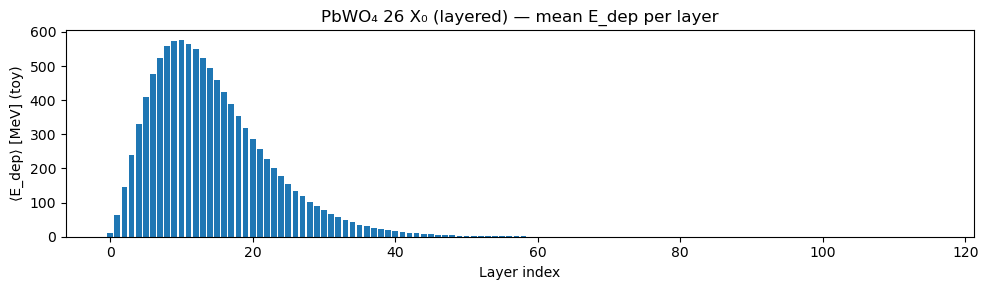

In [20]:
area = area_rect_m2(50, 50)  # 50×50 cm slab

gd_pwo, ct_pwo, spec_pwo = build_ecal_pwo26_layered(area, slice_cm=0.2)
sum_pwo = ct_pwo.summary()

print("ECAL: 26 X0 PbWO4 (layered, ACTIVE)")
print(f"  layers: {spec_pwo['layers']}, total X0≈{spec_pwo['total_X0']:.2f}")
print(f"  length: {spec_pwo['total_length_cm']:.2f} cm")
print(f"  cost:   {sum_pwo['total_cost_chf']:.0f} CHF")

df_pwo = run_parametric_sample_from_gd(gd_pwo, n_events=300, seed=11)
plot_mean_bar(df_pwo, "PbWO₄ 26 X₀ (layered) — mean E_dep per layer")



ECAL: Hybrid PbWO4(front) + Pb/Sc sampling
  front PbWO4: 4.0 X0 in 18 active slices
  periods:     82
  total X0≈    26.16
  length:      24.06 cm
  cost:        27622 CHF  <-- should be < 50k CHF
  layers:      182


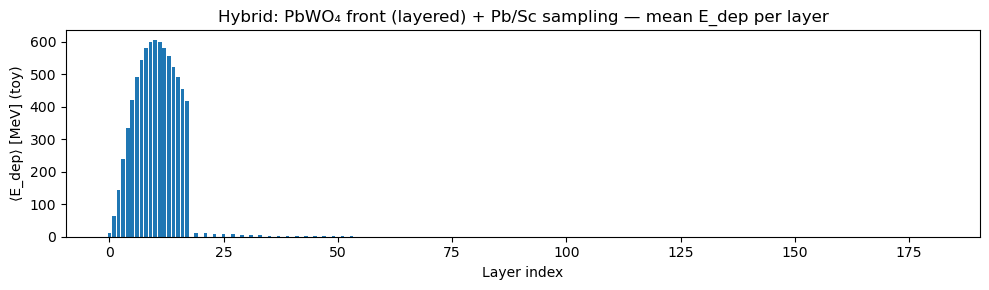

In [24]:
gd_h, ct_h, spec_h = build_ecal_hybrid_layered(
    area,
    front_pwo_X0=4.0,      # try 2–6 X0; cost scales linearly
    pwo_slice_cm=0.2,      # thin active slices so they show up as multiple bars
    t_pb_cm=0.15,          # Pb absorber per period
    t_sc_cm=0.10,          # scintillator (ACTIVE) per period
    total_target_X0=26.0
)
sum_h = ct_h.summary()

print("\nECAL: Hybrid PbWO4(front) + Pb/Sc sampling")
print(f"  front PbWO4: {spec_h['front_pwo_X0']} X0 in {spec_h['front_layers']} active slices")
print(f"  periods:     {spec_h['periods']}")
print(f"  total X0≈    {spec_h['total_X0']:.2f}")
print(f"  length:      {spec_h['total_length_cm']:.2f} cm")
print(f"  cost:        {sum_h['total_cost_chf']:.0f} CHF  <-- should be < 50k CHF")
print(f"  layers:      {spec_h['total_layers']}")

df_h = run_parametric_sample_from_gd(gd_h, n_events=300, seed=22)
plot_mean_bar(df_h, "Hybrid: PbWO₄ front (layered) + Pb/Sc sampling — mean E_dep per layer")


In [ ]:
from G4Calo import GeometryDescriptor
from Simulations import run_batch, plot_longitudinal

# build a quick sampling ECAL (example)
gd = GeometryDescriptor(area_m2=0.25)
for _ in range(60):  # e.g. 60 periods of 0.2 cm Pb + 0.1 cm scint
    gd.addLayer(0.20, "G4_Pb", False)
    gd.addLayer(0.10, "G4_POLYSTYRENE", True)

# run (your favorite signature)
df = run_batch(gd, 200, 'gamma', 1.0, 20, "simulation_data")

# plot longitudinal bars (layer-binned if possible)
plot_longitudinal(df, "Sampling ECAL (γ, 1 GeV)")


/opt/anaconda3/envs/g4-notebooks/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/opt/anaconda3/envs/g4-notebooks/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because

In [1]:
import importlib, Trackers
importlib.reload(Trackers)

<module 'Trackers' from '/Users/egeeroglu/Desktop/Notebooks/Trackers.py'>

In [2]:
import importlib, Simulations
importlib.reload(Simulations)

<module 'Simulations' from '/Users/egeeroglu/Desktop/Notebooks/Simulations.py'>

In [3]:
# --- imports ---
from Trackers import area_rect_m2, CostTracker
from Design import build_ecal_pbwo4_26X0_then_graded_fe_scint_hcal_200cm_v1
from Simulations import run_parametric_sample_from_gd, plot_mean_bar

# --- geometry & cost ---
area = area_rect_m2(50, 50)  # 50×50 cm front face
ct = CostTracker(area_m2=area)

gd, spec = build_ecal_pbwo4_26X0_then_graded_fe_scint_hcal_200cm_v1(cost_tracker=ct)
sum_ = ct.summary()

print("Design A: PbWO₄ ECAL (26 X₀, layered ACTIVE) + graded Fe/Scint HCAL")
print(f"  ECAL length: {spec['ecal_len_cm']:.2f} cm, HCAL length: {spec['hcal_len_cm']:.2f} cm")
print(f"  Total length: {spec['total_len_cm']:.2f} cm")
print(f"  Total cost:   {sum_['total_cost_chf']:.0f} CHF")




Design A: PbWO₄ ECAL (26 X₀, layered ACTIVE) + graded Fe/Scint HCAL
  ECAL length: 23.14 cm, HCAL length: 177.20 cm
  Total length: 200.34 cm
  Total cost:   175071 CHF


  ECAL length: 24.00 cm, HCAL length: 174.60 cm
  Total length: 198.60 cm
  Total cost:   2300 CHF

**************************************************************
 Geant4 version Name: geant4-11-03-patch-02 [MT]   (25-April-2025)
                       Copyright : Geant4 Collaboration
                      References : NIM A 506 (2003), 250-303
                                 : IEEE-TNS 53 (2006), 270-278
                                 : NIM A 835 (2016), 186-225
                             WWW : http://geant4.org/
**************************************************************

G4PhysListFactory::GetReferencePhysList <FTFP_BERT>  EMoption= 0
<<< Geant4 Physics List simulation engine: FTFP_BERT



 hInelastic FTFP_BERT : threshold between BERT and FTFP is over the interval 
 for pions :   3 to 6 GeV
 for kaons :   3 to 6 GeV
 for proton :  3 to 6 GeV
 for neutron : 3 to 6 GeV

### Adding tracking cuts for neutron  TimeCut(ns)= 10000  KinEnergyCut(MeV)= 0
======                 Elect

[g4python] hits buffered: 2257


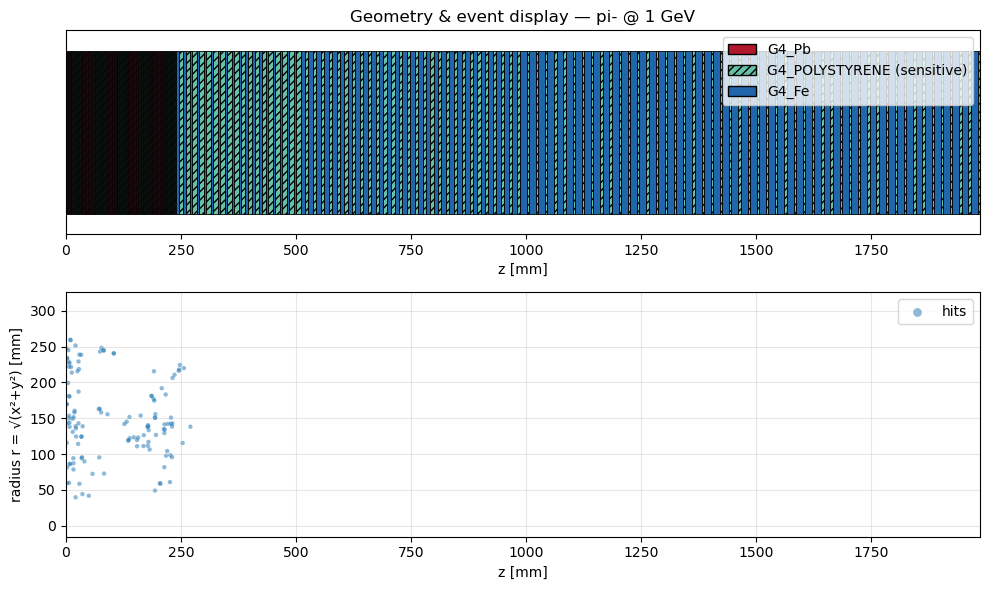

: 

In [ ]:
from viz_event import display_event 
from Trackers import area_rect_m2, CostTracker
from Design import build_pb_scint_ecal_then_graded_fe_scint_hcal_200cm_v2
area = area_rect_m2(50, 50)  # 50×50 cm front face
ct = CostTracker(area_m2=area)
gd, spec = build_pb_scint_ecal_then_graded_fe_scint_hcal_200cm_v2(cost_tracker=ct)
sum_ = ct.summary()

print(f"  ECAL length: {spec['ecal_len_cm']:.2f} cm, HCAL length: {spec['hcal_len_cm']:.2f} cm")
print(f"  Total length: {spec['total_len_cm']:.2f} cm")
print(f"  Total cost:   {sum_['total_cost_chf']:.0f} CHF")
display_event(gd, "pi-", 1.0)          # 1 GeV π⁺, 1 event

  Total length: 200.00 cm
  Total cost:   47192 CHF

**************************************************************
 Geant4 version Name: geant4-11-03-patch-02 [MT]   (25-April-2025)
                       Copyright : Geant4 Collaboration
                      References : NIM A 506 (2003), 250-303
                                 : IEEE-TNS 53 (2006), 270-278
                                 : NIM A 835 (2016), 186-225
                             WWW : http://geant4.org/
**************************************************************

G4PhysListFactory::GetReferencePhysList <FTFP_BERT>  EMoption= 0
<<< Geant4 Physics List simulation engine: FTFP_BERT



 hInelastic FTFP_BERT : threshold between BERT and FTFP is over the interval 
 for pions :   3 to 6 GeV
 for kaons :   3 to 6 GeV
 for proton :  3 to 6 GeV
 for neutron : 3 to 6 GeV

### Adding tracking cuts for neutron  TimeCut(ns)= 10000  KinEnergyCut(MeV)= 0
======                 Electromagnetic Physics Parameters      ========
LPM

[g4python] hits buffered: 1695


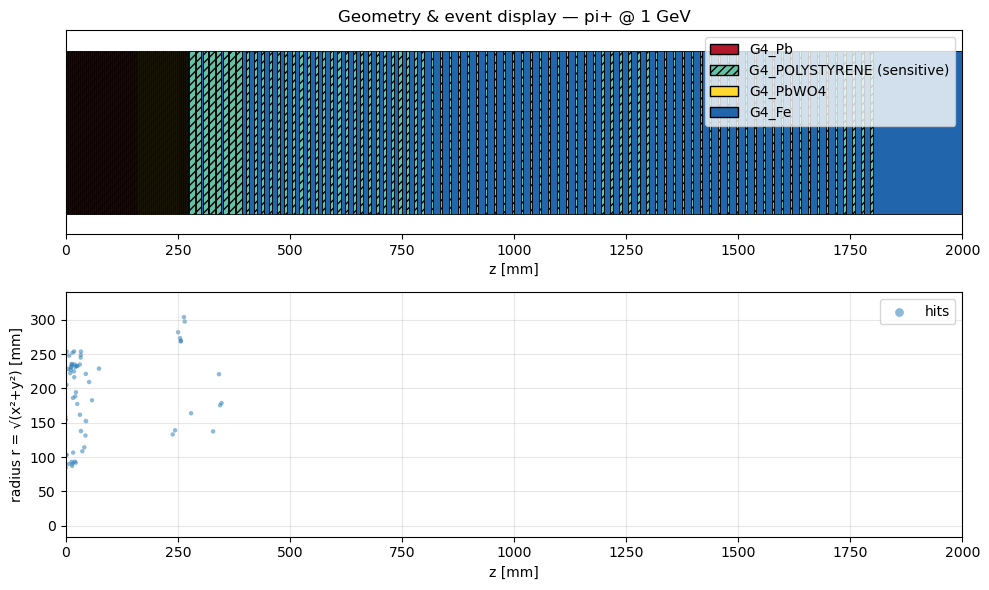

In [ ]:
from Trackers import area_rect_m2, CostTracker
from Design import build_triple_ecal_then_fe_scint_hcal_2m_v4_2
from viz_event import display_event 
area = area_rect_m2(50, 50)  # 50×50 cm front face
ct = CostTracker(area_m2=area)
gd, spec = build_triple_ecal_then_fe_scint_hcal_2m_v4_2(cost_tracker=ct)
sum_ = ct.summary()

#print(f"  ECAL length: {spec['ecal_len_cm']:.2f} cm, HCAL length: {spec['hcal_len_cm']:.2f} cm")
print(f"  Total length: {spec['total_len_cm']:.2f} cm")
print(f"  Total cost:   {sum_['total_cost_chf']:.0f} CHF")
display_event(gd, "pi+", 1.0)          # 1 GeV π⁺, 1 event